# LAB 2.4 - Model instrumentation

The labs require a `tensorflow` version lower than the default one used in Google Colab. Run the following cell to downgrade TensorFlow accordingly.

In [ ]:
!wget -nc --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2021.deeplearning/main/content/init.py
import init; init.init(force_download=False); init.get_weblink()

In [ ]:
from local.lib.rlxmoocapi import submit, session
import inspect
session.LoginSequence(endpoint=init.endpoint, course_id=init.course_id, session_id='udea.pre.20252', lab_id="L02.04", varname="student");

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
from IPython.display import Image
import pandas as pd

%matplotlib inline

### LAB SUMMARY


In this lab you will be implementing Tensorflow Callbacks that will be invoked at different stages when a model gets trained.

Read carefully the following tutorial: [https://www.tensorflow.org/guide/keras/custom_callback](https://www.tensorflow.org/guide/keras/custom_callback)


### load sample MNIST data as customary

In [5]:
mnist = pd.read_csv("local/data/mnist1.5k.csv.gz", compression="gzip", header=None).values
X=mnist[:,1:785]/255.
y=mnist[:,0]
print("dimension de las imagenes y las clases", X.shape, y.shape)

dimension de las imagenes y las clases (1500, 784) (1500,)


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
X_train = X_train.astype(np.float32)
X_test  = X_test.astype(np.float32)
y_train_oh = np.eye(10)[y_train]
y_test_oh  = np.eye(10)[y_test]
print(X_train.shape, y_train_oh.shape)

(1200, 784) (1200, 10)


In [7]:
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import Callback

### A basic multi layered dense model

observe that the function allows us to parametrize the number of hidden layers and their activation function


In [8]:
def get_model(input_dim=784, output_dim=10, num_hidden_layers=6, hidden_size=10, activation="relu"):

    model = Sequential()
    model.add(Dense(hidden_size, activation=activation, input_dim=input_dim, name="Layer_%02d_Input"%(0)))

    for i in range(num_hidden_layers):
        model.add(Dense(hidden_size, activation=activation, name="Layer_%02d_Hidden"%(i+1)))

    model.add(Dense(output_dim, activation="softmax", name="Layer_%02d_Output"%(num_hidden_layers+1)))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

## TASK 1: Weights monitoring callback

Create a callback that:

- when each epoch ends, retrieves the weights of the layer with name `self.layer_name`.
- gets is kernels weights.
- computes the mean and standard deviation of those weights.
- appends them to `self.mean_per_epoch` and `self.std_per_epoch`

When used with a model, at the end of any training it will contain a list of weights means and another list of weights stds, both with one element per each epoch. With this we can monitor how the weights in a specific layer progress over the training process. Tensorboard offers a similar functionality, but the goal with this task is to get acquainted with the callback mechanism.

In [ ]:
def LayerWeightsCallback(model, layer_name):
    class LayerWeightsCallback_class(Callback):

        def __init__(self, model, layer_name):
            super().__init__()
            self.mean_per_epoch = []
            self.std_per_epoch = []
            self.layer_name = layer_name
            self.user_model = model

        def on_epoch_end(self, epoch, logs=None):
            w = ... # get the weights from layer_name in self.user_model
            ... # append to self.mean_per_epoch the weights mean
            ... # append to self.std_per_epoch the weights std

    return LayerWeightsCallback_class(model, layer_name)

manually test your code with the following cell. Your callback should report the weights mean and std doubling at every epoch, just with the same values as they are being computed within the for loop. The loop simulates training epochs.

In [ ]:
model = get_model(input_dim=2, output_dim=3, num_hidden_layers=1, hidden_size=2, activation="sigmoid")
layer_names = [i.name for i in model.layers if not "Input" in i.name]
layer = model.get_layer(np.random.choice(layer_names))

cb = LayerWeightsCallback(model, layer.name)

m, s, wh = [], [], []
for epoch in range(3):
    w = layer.get_weights()[0]
    wh.append(w)
    print ("epoch", epoch, "weights mean/std", np.mean(w),np.std(w))
    cb.on_epoch_end(epoch)
    layer.set_weights([i*2 for i in layer.get_weights()])

print ("\nweight mean at each epoch", cb.mean_per_epoch)
print ("weight std  at each epoch", cb.std_per_epoch)

Now you can use your class to keep track of weights while training. We choose to keep track of weights with your callback for all the layers.

Observe how we plot the weights progress with the data gathered by your callback. What interpretation can you give to the plots?

In [ ]:
model = get_model(num_hidden_layers=3, activation="sigmoid")
cbs = [LayerWeightsCallback(model, i.name) for i in model.layers]
model.fit(X_train, y_train_oh, epochs=100, batch_size=8,
          validation_data=(X_test, y_test_oh), callbacks=cbs)

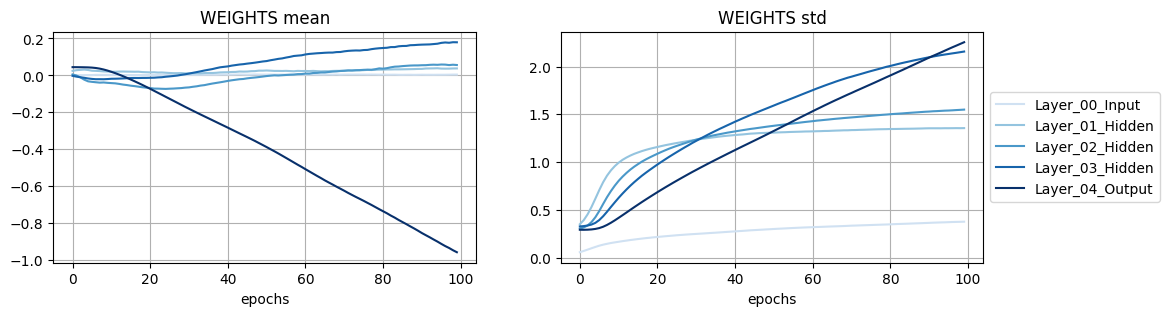

In [25]:

def plot_epochs(cbset, title=""):
    cm = plt.cm.Blues
    plt.figure(figsize=(12,3))
    plt.subplot(121)
    for i,cb in enumerate(cbset):
        plt.plot(cb.mean_per_epoch, label=cb.layer_name, color=cm(int(255*(i+1)/(len(cbset)))))
        plt.xlabel("epochs"); plt.grid(); plt.title(title+" mean")
    plt.subplot(122)
    for i,cb in enumerate(cbset):
        plt.plot(cb.std_per_epoch, label=cb.layer_name, color=cm(int(255*(i+1)/(len(cbset)))))
        plt.xlabel("epochs"); plt.grid(); plt.title(title+" std")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plot_epochs(cbs, "WEIGHTS")


**Registra tu solución en linea**

In [ ]:
student.submit_task(namespace=globals(), task_id='T1');

## TASK 2: Activations monitoring callback


observe how, given a model and a certain input, we can get the activations at different layers in a very straight forward manner. If we do this before training (`.fit`) it is also ok, the model will simply use the initial random weights.

In [ ]:
model = get_model(num_hidden_layers=3, activation="sigmoid")
model.summary()

In [ ]:
activations_layer_0 = model.layers[0](X_train)
activations_layer_1 = model.layers[1](activations_layer_0)
activations_layer_0.shape, activations_layer_1.shape

Create a callback that:

- when each epoch ends, feeds `self.X` into the model and retrieves the activations at the output of layer with name `self.layer_name`.
- computes the mean and standard deviation of those activations.
- appends them to `self.mean_per_epoch` and `self.std_per_epoch`

When used with a model, at the end of any training it will contain a list of activations means and another list of activation stds, both with one element per each epoch. With this we can monitor how the activation in a specific layer progress over the training process. Tensorboard offers a similar functionality, but the goal with this task is to get acquainted with the callback mechanism.

In [ ]:
def TrainValActivationsCallback(layer_name, X):
    class TrainValActivationsCallback_class(Callback):

        def __init__(self, model, layer_name, X):
            super().__init__()
            self.mean_per_epoch = []
            self.std_per_epoch = []
            self.layer_name = layer_name
            self.X = X
            self.user_model = model

        def on_epoch_end(self, epoch, logs=None):
            a = ... # feed self.X into self.user_model and get the activations at layer_name
            ... # append to self.mean_per_epoch the activations mean
            ... # append to self.std_per_epoch the activations std

    return TrainValActivationsCallback_class(layer_name, X)

test your code with the following cell. Observe that

- we create a small input dataset and model
- invoke your callback implementation
- your callback must contain two lists: `mean_per_epoch` and `std_per_epoch` with one single value each
- you can check that single value with our computation. We do this computation in two different ways (1) by using explicitly the model layers; and (2) by using matrix multiplication with layers weights (`linear activation`== `no activation`)

In [ ]:
X_in = np.random.random(size=(5,2)).astype(np.float32)
print ("input data\n", X_in)
model = get_model(input_dim=2, output_dim=3, num_hidden_layers=2, hidden_size=2, activation="linear")
layer_name = 'Layer_02_Hidden'
layer = model.get_layer(layer_name)

cb = TrainValActivationsCallback(model, layer.name, X_in)
cb.on_epoch_end(epoch)

print ("\nactivations at", layer_name)
print ("\nactivation mean/std with your callback", cb.mean_per_epoch, cb.std_per_epoch)

l0,l1,l2,l3 = model.layers
a = l2(l1(l0(X_in))).numpy()
print ("using model layer functions            ", a.mean(), a.std())

a = X_in.dot(l0.get_weights()[0]).dot(l1.get_weights()[0]).dot(l2.get_weights()[0])
print ("manual matrix mult linear activation   ", a.mean(), a.std())

Now you can use your class to keep track of activations while training. We choose to keep track of activations with your callback for all the layers.

Observe how we plot the activations progress with the data gathered by your callback. What interpretation can you give to the plots?

In this case, we are creating a callback for each layer for train and for test data. If activations are similar in both train and test it may mean that the train/test splits are being treated similarly by the model.

In [ ]:
model = get_model(num_hidden_layers=3, activation="sigmoid")
cbs_train = [TrainValActivationsCallback(model, i.name, X_train) for i in model.layers]
cbs_test  = [TrainValActivationsCallback(model, i.name, X_test) for i in model.layers]
model.fit(X_train, y_train_oh, epochs=100, batch_size=32,
          validation_data=(X_test, y_test_oh), callbacks=cbs_train+cbs_test)

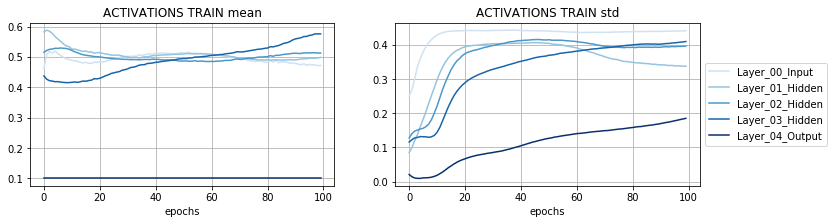

In [ ]:
plot_epochs(cbs_train, "ACTIVATIONS TRAIN")

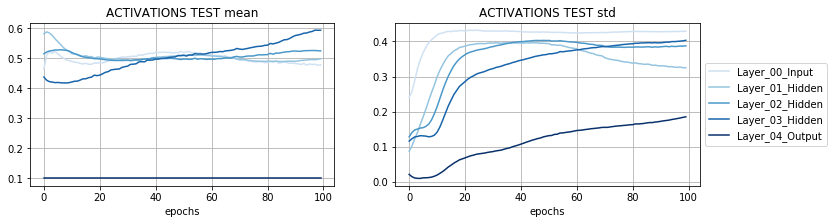

In [ ]:

plot_epochs(cbs_test, "ACTIVATIONS TEST")


**Registra tu solución en linea**

In [ ]:
student.submit_task(namespace=globals(), task_id='T2');